<a href="https://colab.research.google.com/github/iknyazeva/InverseProblem/blob/main/notebooks/model_training_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Here is an exmaple of training.**



In [ ]:
!git clone https://github.com/iknyazeva/InverseProblem

Cloning into 'InverseProblem'...
remote: Enumerating objects: 615, done.
remote: Counting objects: 100% (615/615), done.
remote: Compressing objects: 100% (369/369), done.
remote: Total 615 (delta 445), reused 404 (delta 243), pack-reused 0
Receiving objects: 100% (615/615), 2.65 MiB | 7.80 MiB/s, done.
Resolving deltas: 100% (445/445), done.


In [ ]:
cd InverseProblem

/content/InverseProblem


In [ ]:
import sys
sys.path.append('InverseProblem')

In [ ]:
from inverse_problem.nn_inversion.main import HyperParams, Model
from inverse_problem import get_project_root
from inverse_problem.milne_edington.me import read_full_spectra
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params

import json
from pprint import pprint
import os
from astropy.io import fits
import matplotlib.pyplot as plt

from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path

First thing first, we need to download data

In [ ]:
# training data

data_id = '12GslrX_J0Pw9jfr23oWoJ5gDb_I91Mj7'
gdd.download_file_from_google_drive(file_id=data_id,
                                    dest_path='data/parameters_base.fits', showsize=True)

271.9 MiB Done.


In [ ]:
# real data for testing

ref_id ='1ylXZjKTx0riGwq520f2IuD4k_z3z5piN'
gdd.download_file_from_google_drive(file_id=ref_id,
                                    dest_path='data/reference.fits', showsize=True)

refer_path = '/content/InverseProblem/data/reference.fits'
refer, names = open_param_file(refer_path)

35.9 MiB Done.
Open file with 36 available paramters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Original_Continuum_Intensity
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift


# Common model

Simple MLP model

In [ ]:
# all hyperparameters are stored in json

path_to_json = '/content/InverseProblem/res_experiments/hps_common_mlp.json'
with open(path_to_json) as f:
    json_data = json.load(f)
    pprint(json_data)

{'activation': 'elu',
 'batch_norm': True,
 'batch_size': 128,
 'bottom_net': 'BottomMLPNet',
 'bottom_output': 100,
 'cont_scale': 40000,
 'dropout': 0.05,
 'factors': [1, 1000, 1000, 1000],
 'hidden_dims': [100, 100],
 'hps_name': 'hps_common_mlp',
 'logB': True,
 'n_epochs': 5,
 'n_input': 224,
 'norm_output': True,
 'predict_ind': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'source': 'database',
 'top_layers': 2,
 'top_net': 'TopCommonMLPNet',
 'top_output': 11,
 'trainset': None,
 'transform_type': 'mlp_transform_rescale',
 'val_split': 0.05,
 'valset': None}


In [ ]:
# read hyperparameters from file
hps = HyperParams.from_file(path_to_json=path_to_json)

# we can change parameters, lets change batch size
hps.batch_size = 1024

model = Model(hps)
model.net

FullModel(
  (bottom): BottomMLPNet(
    (mlp): MLPBlock(
      (FC_layers): ModuleList(
        (0): MLPlayer(
          (linear): Linear(in_features=224, out_features=100, bias=True)
          (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
        (1): MLPlayer(
          (linear): Linear(in_features=100, out_features=100, bias=True)
          (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
        (2): MLPlayer(
          (linear): Linear(in_features=100, out_features=100, bias=True)
          (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
      )
    )
  )
  (top): TopCommonMLPNet(
    (mlp): MLPReadout(
      (FC_layers): ModuleList(
        (0): MLPlayer

In [ ]:
print("Number of training parameters:", sum(p.numel() for p in model.net.parameters() if p.requires_grad))

Number of training parameters: 50133


## Model training

Provide path to data if you want to train model on whole dataset

In [ ]:
history = model.train(
    filename='/content/InverseProblem/data/parameters_base.fits',
    logdir = '/content/', # path to save logs
    path_to_save='/content/common_mlp2.pt') # path to save model

Or train model on a small part of dataset

In [ ]:
# preveously downloaded data
params = fits.open('/content/InverseProblem/data/parameters_base.fits')[0].data

history = model.train(
    data_arr=params[:500],
    logdir = '/content/', 
    path_to_save='/content/common_mlp.pt')

batch:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.2978          val_loss 0.2184


batch:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.2130          val_loss 0.2159


batch:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.2111          val_loss 0.2131


batch:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.2084          val_loss 0.2091


epoch: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 005 train_loss: 0.2059          val_loss 0.2058


Also we can load model

In [ ]:
# download weights
model_id = '1iT4I7l6pqPxhbVc_J7pNYSz0oh1ZEnEX'
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path='/content/models/common_mlp.pt', showsize=True)

model.load_model('/content/models/common_mlp.pt')

608.0 KiB Done.


And continue training

In [ ]:
model.continue_training(
    checkpoint_path='/content/models/common_mlp.pt', 
    data_arr=params[:500], # we can use all arguments from train function
    scheduler=False)

# and save model
path_to_save = '/content/continue.pt'
model.save_model(path_to_save)

batch:   0%|          | 0/1 [00:00<?, ?it/s]

model was saved at 4 epoch with 0.0054919611425194225 validation loss


batch:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 001 train_loss: 0.0251          val_loss 0.0212


batch:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.0234          val_loss 0.0184


batch:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.0204          val_loss 0.0166


batch:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.0179          val_loss 0.0146


epoch: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 005 train_loss: 0.0156          val_loss 0.0124


## Testing

In [ ]:
predicted_common = model.predict_refer('/content/InverseProblem/data/reference.fits')

  0%|          | 0/248 [00:00<?, ?it/s]

Open file with 36 available paramters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Original_Continuum_Intensity
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift


100%|██████████| 248/248 [00:47<00:00,  5.27it/s]


In [ ]:
df_common = compute_metrics(refer, predicted_common, names, save_path = '/content/common_pred.csv')
df_common

,r2,mse,mae
Field_Strength,0.780,0.017,0.107
Field_Inclination,0.872,0.003,0.031
Field_Azimuth,0.573,0.031,0.108
Doppler_Width,0.840,0.007,0.062
Damping,0.725,0.011,0.074
Line_Strength,0.241,0.018,0.068
Original_Continuum_Intensity,0.713,0.048,0.212
Source_Function_Gradient,0.943,0.016,0.125
Doppler_Shift2,0.700,0.001,0.018
Stray_Light_Fill_Factor,0.518,0.115,0.274


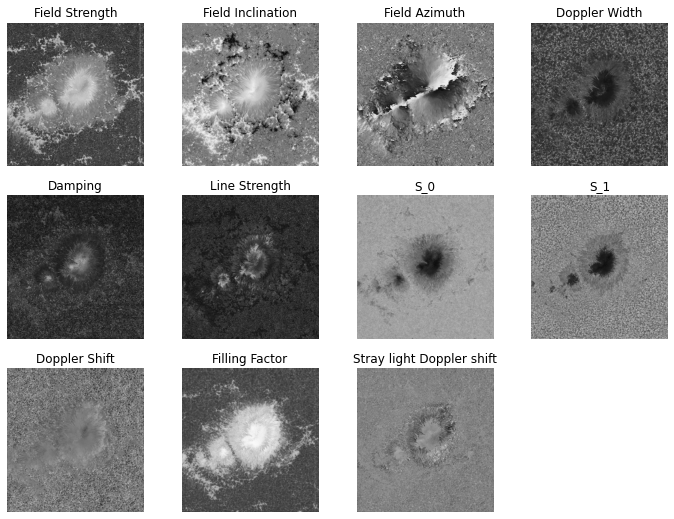

In [ ]:
plot_params(predicted_common)

# Partly indipendent

One shared MLP and eleven independent models

In [ ]:
path_to_json = '/content/InverseProblem/res_experiments/hps_partly_independent_mlp.json'
with open(path_to_json) as f:
    json_data = json.load(f)
    pprint(json_data)

{'activation': 'elu',
 'batch_norm': True,
 'batch_size': 128,
 'bottom_net': 'BottomMLPNet',
 'bottom_output': 100,
 'cont_scale': 40000,
 'dropout': 0.05,
 'factors': [1, 1000, 1000, 1000],
 'hidden_dims': [100, 100],
 'hps_name': 'hps_partly_independent_mlp',
 'logB': True,
 'n_epochs': 5,
 'n_input': 224,
 'predict_ind': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'source': 'database',
 'top_layers': 2,
 'top_net': 'TopIndependentNet',
 'top_output': 11,
 'trainset': None,
 'transform_type': 'mlp_transform_rescale',
 'val_split': 0.01,
 'valset': None}


In [ ]:
hps = HyperParams.from_file(path_to_json=path_to_json)

hps.batch_size = 1024

model = Model(hps)
model.net

FullModel(
  (bottom): BottomMLPNet(
    (mlp): MLPBlock(
      (FC_layers): ModuleList(
        (0): MLPlayer(
          (linear): Linear(in_features=224, out_features=100, bias=True)
          (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
        (1): MLPlayer(
          (linear): Linear(in_features=100, out_features=100, bias=True)
          (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
        (2): MLPlayer(
          (linear): Linear(in_features=100, out_features=100, bias=True)
          (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
      )
    )
  )
  (top): TopIndependentNet(
    (task_layers): ModuleList(
      (0): Sequential(
        (0): MLPBlo

In [ ]:
print("Number of training parameters:", sum(p.numel() for p in model.net.parameters() if p.requires_grad))

Number of training parameters: 342533


In [ ]:
history = model.train(
    data_arr=params[:5000], 
    logdir = "/content/", 
    path_to_save='/content/partly_ind_mlp.pt')

batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.2659          val_loss 0.2107


batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.2056          val_loss 0.1931


batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.1848          val_loss 0.1701


batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.1601          val_loss 0.1444


epoch: 100%|██████████| 5/5 [00:29<00:00,  5.81s/it]


Epoch 005 train_loss: 0.1348          val_loss 0.1213


In [ ]:
model_id = '1-BKVkbSVCIUwD6UaaSWwVecMUr7UiHkl'
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path='/content/models/partly_mlp.pt', showsize=True)

model.load_model('/content/models/partly_mlp.pt')

4.2 MiB Done.


In [ ]:
predicted_partly = model.predict_refer('/content/InverseProblem/data/reference.fits')

  0%|          | 0/248 [00:00<?, ?it/s]

Open file with 36 available paramters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Original_Continuum_Intensity
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift


100%|██████████| 248/248 [00:49<00:00,  4.99it/s]


In [ ]:
df_partly = compute_metrics(refer, predicted_partly, names, save_path = '/content/partly_pred.csv')
df_partly

,r2,mse,mae
Field_Strength,0.905,0.002,0.025
Field_Inclination,0.902,0.002,0.023
Field_Azimuth,0.635,0.026,0.086
Doppler_Width,0.941,0.001,0.023
Damping,0.922,0.002,0.029
Line_Strength,0.546,0.011,0.058
Original_Continuum_Intensity,0.975,0.000,0.017
Source_Function_Gradient,0.987,0.000,0.011
Doppler_Shift2,0.888,0.000,0.009
Stray_Light_Fill_Factor,0.835,0.013,0.079


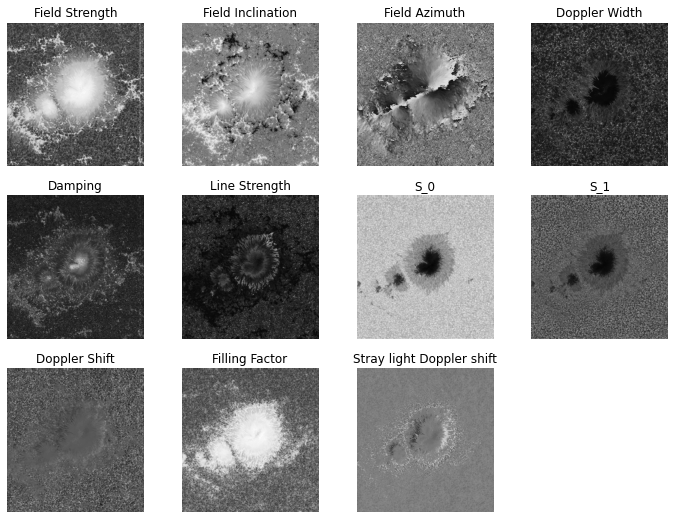

In [ ]:
plot_params(predicted_partly)

# Independent models

Eleven fully independent models

In [ ]:
path_to_json = '/content/InverseProblem/res_experiments/hps_independent_mlp.json'
with open(path_to_json) as f:
    json_data = json.load(f)
    pprint(json_data)

{'activation': 'elu',
 'batch_norm': True,
 'batch_size': 128,
 'bottom_net': 'ZeroMLP',
 'bottom_output': 224,
 'cont_scale': 40000,
 'dropout': 0.05,
 'factors': [1, 1000, 1000, 1000],
 'hidden_dims': [100, 100, 100],
 'hps_name': 'hps_independent_mlp',
 'logB': True,
 'n_epochs': 5,
 'n_input': 224,
 'norm_output': True,
 'predict_ind': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'source': 'database',
 'top_layers': 3,
 'top_net': 'TopIndependentNet',
 'top_output': 11,
 'trainset': None,
 'transform_type': 'mlp_transform_rescale',
 'val_split': 0.01,
 'valset': None}


In [ ]:
hps = HyperParams.from_file(path_to_json=path_to_json)

hps.batch_size = 1024

model = Model(hps)
model.net

FullModel(
  (bottom): ZeroMLP()
  (top): TopIndependentNet(
    (task_layers): ModuleList(
      (0): Sequential(
        (0): MLPBlock(
          (FC_layers): ModuleList(
            (0): MLPlayer(
              (linear): Linear(in_features=225, out_features=100, bias=True)
              (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (dropout): Dropout(p=0.05, inplace=False)
            )
            (1): MLPlayer(
              (linear): Linear(in_features=100, out_features=100, bias=True)
              (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (dropout): Dropout(p=0.05, inplace=False)
            )
            (2): MLPlayer(
              (linear): Linear(in_features=100, out_features=100, bias=True)
              (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (dropout): Dropout(p=0.05, inpl

In [ ]:
print("Number of training parameters:", sum(p.numel() for p in model.net.parameters() if p.requires_grad))

Number of training parameters: 553762


In [ ]:
history = model.train(
    data_arr=params[:5000], 
    logdir = "/content/", 
    path_to_save='/content/ind_mlp.pt')

batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.2924          val_loss 0.3006


batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.2916          val_loss 0.2655


batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.2557          val_loss 0.2236


batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.2174          val_loss 0.1861


epoch: 100%|██████████| 5/5 [00:29<00:00,  5.93s/it]


Epoch 005 train_loss: 0.1816          val_loss 0.1476


In [ ]:
model_id = '1rG9AXK1We2bj3QR7xasYlmMobd58n8M0'
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path='/content/models/ind_mlp.pt', showsize=True)

model.load_model('/content/models/ind_mlp.pt')

6.7 MiB Done.


In [ ]:
predicted_ind = model.predict_refer('/content/InverseProblem/data/reference.fits')

  0%|          | 0/248 [00:00<?, ?it/s]

Open file with 36 available paramters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Original_Continuum_Intensity
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift


100%|██████████| 248/248 [00:50<00:00,  4.94it/s]


In [ ]:
df_ind = compute_metrics(refer, predicted_ind, names, save_path = '/content/ind_pred.csv')
df_ind

,r2,mse,mae
Field_Strength,0.899,0.002,0.026
Field_Inclination,0.894,0.003,0.023
Field_Azimuth,0.618,0.028,0.090
Doppler_Width,0.930,0.001,0.024
Damping,0.893,0.003,0.029
Line_Strength,0.521,0.010,0.053
Original_Continuum_Intensity,0.966,0.001,0.019
Source_Function_Gradient,0.983,0.000,0.012
Doppler_Shift2,0.875,0.000,0.009
Stray_Light_Fill_Factor,0.799,0.015,0.087


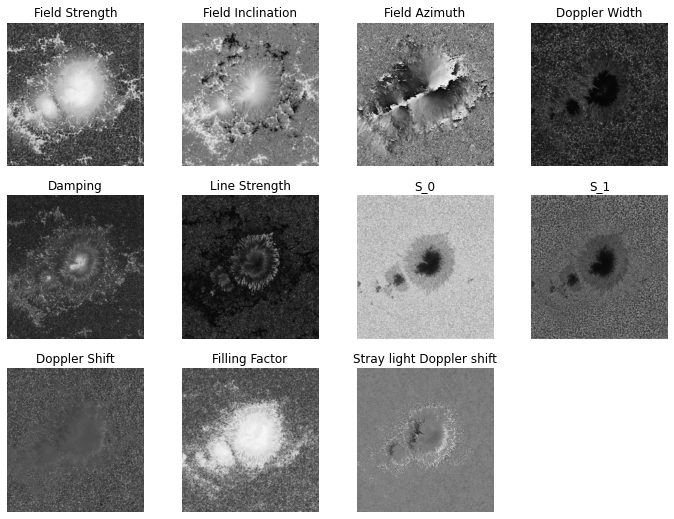

In [ ]:
plot_params(predicted_ind)